In [1]:
# uncomment this to use CPU instead of GPU
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import tensorflow as tf
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce
from tensorflow import keras
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

### Load MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

format dataset as square images or as matrices so we can use convolutional layers

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


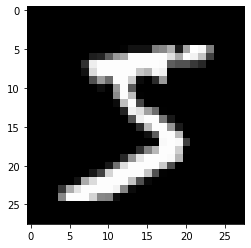

In [5]:
plt.figure()
plt.imshow(x_train[0, :, :, 0], cmap='gray')

In [6]:
batch_size = 100
img_width = x_train.shape[1]
img_height = x_train.shape[2]
channels = x_train.shape[3] # images are in black and white, for RGB we have 3 channels (r,g,b)

### Now we define the Convolutional Autoencoder - CAE

```
input --> encoder --> latent_space --> decoder --> reconstructed_image
input_img              encoder output                 decoded_output
```

In [7]:
conv_shape = (3, 3)

Encoder

In [8]:
input_img = Input(shape=(img_width, img_height, channels))
x = Conv2D(16, conv_shape, activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, conv_shape, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

decoder

In [9]:
x = Conv2D(8, conv_shape, activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(channels, conv_shape, activation='sigmoid', padding='same')(x)

dimensionality reduction?

In [10]:
img_height * img_width / int(reduce(lambda x, y: x*y, np.asarray(encoded.shape[1:])))

2.0

In [11]:
encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
encoded (MaxPooling2D)       (None, 7, 7, 8)           0         
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [12]:
autoencoder = Model(input_img, decoded, name='convolutional_autoencoder')
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.summary()

Model: "convolutional_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
encoded (MaxPooling2D)       (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 1

#### callbacks

We are going to use early stopping and reduce lr on pateau callbacks to avoid improve the generalization of the model and avoid overfitting.

Also we are going to add the tensorboard callback to check the training losses during the training process.

In [13]:
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = TensorBoard(
    log_dir=log_dir, 
    profile_batch=0)

es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=12,
    min_delta=0.0001, 
    restore_best_weights=True)

lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=8,
    mi_delta=0.0001)

cb = [tb_cb, es_cb, lr_cb]

Since the target in an autoencoder is the same as the input, both `x` and `y` are the same here.

In [14]:
epochs = 500

autoencoder_train = autoencoder.fit(
    x=x_train, 
    y=x_train,
    batch_size=batch_size,
    epochs=epochs, 
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=cb)

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 5s 80us/sample - loss: 0.2278 - val_loss: 0.2266
Epoch 2/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.2245 - val_loss: 0.2225
Epoch 3/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.2194 - val_loss: 0.2162
Epoch 4/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.2113 - val_loss: 0.2063
Epoch 5/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.1987 - val_loss: 0.1910
Epoch 6/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.1809 - val_loss: 0.1722
Epoch 7/500
60000/60000 [==============================] - 3s 44us/sample - loss: 0.1628 - val_loss: 0.1563
Epoch 8/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.1493 - val_loss: 0.1455
Epoch 9/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.14

Epoch 76/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0276 - val_loss: 0.0272
Epoch 77/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0275 - val_loss: 0.0271
Epoch 78/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0273 - val_loss: 0.0269
Epoch 79/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0272 - val_loss: 0.0268
Epoch 80/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0271 - val_loss: 0.0266
Epoch 81/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0269 - val_loss: 0.0265
Epoch 82/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0268 - val_loss: 0.0264
Epoch 83/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0267 - val_loss: 0.0262
Epoch 84/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0265 - val_loss: 0.0261
Epoch 85/500
60000/

60000/60000 [==============================] - 3s 43us/sample - loss: 0.0197 - val_loss: 0.0192
Epoch 151/500
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0196 - val_loss: 0.0192
Epoch 152/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0195 - val_loss: 0.0191
Epoch 153/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0194 - val_loss: 0.0190
Epoch 154/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0194 - val_loss: 0.0189
Epoch 155/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0193 - val_loss: 0.0189
Epoch 156/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0192 - val_loss: 0.0188
Epoch 157/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0192 - val_loss: 0.0187
Epoch 158/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0191 - val_loss: 0.0187
Epoch 159/500
60000/6000

60000/60000 [==============================] - 3s 43us/sample - loss: 0.0160 - val_loss: 0.0156
Epoch 225/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0160 - val_loss: 0.0156
Epoch 226/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0160 - val_loss: 0.0156
Epoch 227/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0159 - val_loss: 0.0155
Epoch 228/500
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0159 - val_loss: 0.0155
Epoch 229/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0159 - val_loss: 0.0155
Epoch 230/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0158 - val_loss: 0.0154
Epoch 231/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0158 - val_loss: 0.0154
Epoch 232/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0158 - val_loss: 0.0154
Epoch 233/500
60000/6000

60000/60000 [==============================] - 3s 43us/sample - loss: 0.0142 - val_loss: 0.0138
Epoch 299/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0142 - val_loss: 0.0138
Epoch 300/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0142 - val_loss: 0.0138
Epoch 301/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0141 - val_loss: 0.0138
Epoch 302/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0141 - val_loss: 0.0137
Epoch 303/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0141 - val_loss: 0.0137
Epoch 304/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0141 - val_loss: 0.0137
Epoch 305/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0141 - val_loss: 0.0137
Epoch 306/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0141 - val_loss: 0.0137
Epoch 307/500
60000/6000

60000/60000 [==============================] - 3s 43us/sample - loss: 0.0130 - val_loss: 0.0126
Epoch 373/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0130 - val_loss: 0.0126
Epoch 374/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0130 - val_loss: 0.0126
Epoch 375/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0130 - val_loss: 0.0126
Epoch 376/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0130 - val_loss: 0.0126
Epoch 377/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0129 - val_loss: 0.0126
Epoch 378/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0129 - val_loss: 0.0126
Epoch 379/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0129 - val_loss: 0.0126
Epoch 380/500
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0129 - val_loss: 0.0125
Epoch 381/500
60000/6000

In [25]:
saved = False
if not saved:
    autoencoder.save('./cae_model_{}.hdf5'.format(epochs))
    encoder.save('./cae_encoder_{}.hdf5'.format(epochs))    
    saved = True

### Visualize autoencoder results

We choose ten random images from the testing dataset

In [26]:
ind_test = np.random.choice(range(x_test.shape[0]), 10)

In [27]:
test_images = np.take(x_test, ind_test, axis=0)
preds = autoencoder.predict(test_images)

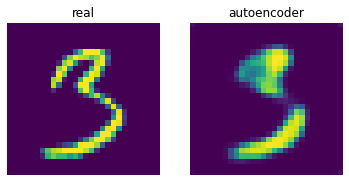

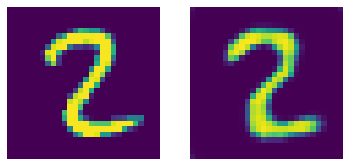

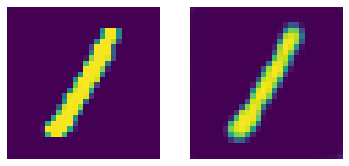

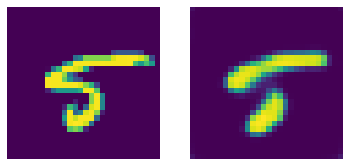

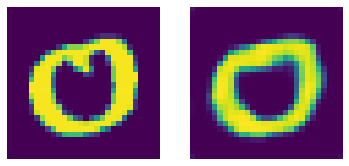

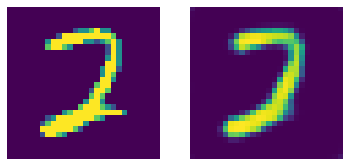

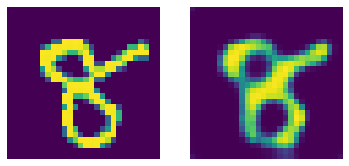

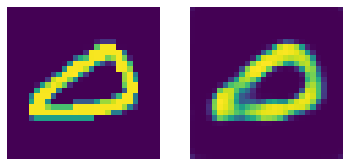

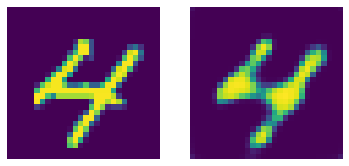

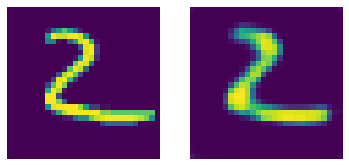

In [28]:
has_title = False
for im, pred in zip(test_images, preds):
    plt.figure()
    
    ax1 = plt.subplot(1,2,1)
    plt.imshow(np.squeeze(im))
    
    ax2 = plt.subplot(1,2,2)
    plt.imshow(np.squeeze(pred))
    
    ax1.axis('off')
    ax2.axis('off')    
    if not has_title:
        ax1.set_title('real')
        ax2.set_title('autoencoder')
        has_title = True

### Latent space visualization

In this particular case since we are using a very simple convolutional netwok the different dimensions of the latent space are going to look very similar to the input.

Probably are edge detections and directions filters.

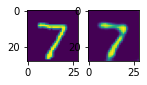

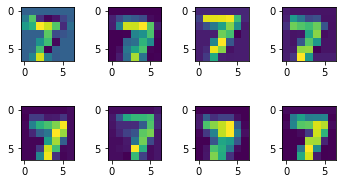

In [29]:
def plot_latents(input_image):
    test_ar = input_image
    pred = autoencoder.predict(test_ar)
    
    for real, coded in zip(test_ar, pred):
        plt.figure(figsize = (2,4))
        plt.subplot(1,2,1)
        plt.imshow(real[:,:,0])
        plt.subplot(1,2,2)
        plt.imshow(coded[:,:,0])   
    
    coded_image = encoder.predict(test_ar)
    coded_dims = coded_image.shape[-1]

    plt.figure(figsize = (5,3))
    for i in range(coded_dims):
        plt.subplot(int(np.ceil(coded_dims)/4),4, i+1)
        plt.imshow(coded_image[0, :, :, i])
    plt.tight_layout()    
    
    return pred, coded_image

_ ,_ = plot_latents(x_test[0:1,:,:,:])

### More latent space visualizations - TSNE

TSNE uses 2d data as input, so we reshape the data from 4d to 2d.
Then we apply TSNE for dimensionality reduction Nsamples, Nd --> Nsamples, 2 dimensions

In [30]:
latent = encoder.predict(x_test)

In [31]:
latent_1d = np.reshape(latent,  (latent.shape[0], int(reduce(lambda x, y: x*y, np.asarray(latent.shape[1:])))))

In [32]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_score
import pandas as pd

In [33]:
latent_tsne = TSNE(n_components=2, random_state=2).fit_transform(latent_1d)
latent_data = pd.DataFrame({
        'x': latent_tsne[:, 0],
        'y': latent_tsne[:, 1],
        'label': y_test})

score: 0.3635343611240387


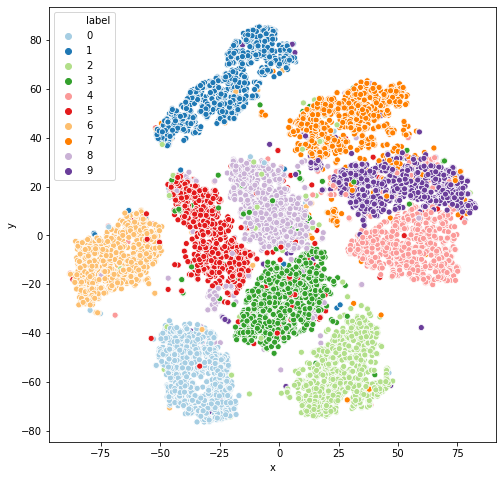

In [34]:
print('score: {}'.format(silhouette_score(latent_tsne, latent_data['label'] )))
fig = plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='x', y='y', hue='label', data=latent_data, palette='Paired')